# Ordinary and Simple Kriging

This tutorial will teach us how to perform spatial interpolation with Ordinary and Simple Kriging. We will compare Kriging behavior in relation to a different number of ranges, and finally check how number of neighbors changes the interpolation quality. Ordinary and Simple Kriging are the simplest form of Kriging, but they're still powerful, thus you should always start from those methods and then move to more sophisticated techniques.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
- **Package**:
  - `TheoreticalVariogram`
  - `ExperimentalVariogram`
- **Programming**:
  - Python basics

## Table of contents

1. Set semivariogram model (**fit** data into semivariogram).
2. Create Ordinary and Simple Kriging models.
3. Predict values at unknown locations and evaluate output.

## 1. Set semivariogram model (fit)


In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyinterpolate import (
    build_experimental_variogram,
    build_theoretical_variogram,
    ordinary_kriging,
    simple_kriging
)

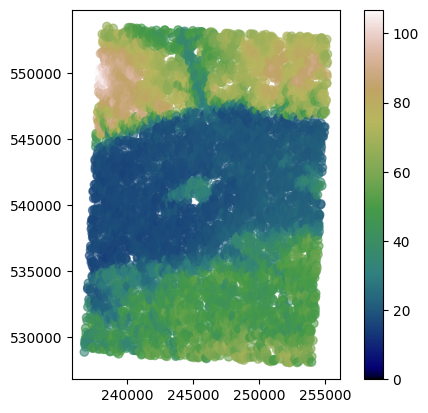

In [2]:
# Load DEM data

df = pd.read_csv(
    '../data/dem.csv'
)
# Populate geometry column and set CRS

dem_geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='epsg:4326')
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

# Transform crs to metric values
dem.to_crs(epsg=2180, inplace=True)
dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

In the beginning, we remove 90 % of our points from the dataset, and we will leave them as a test set to calculate interpolation error of Kriging models.

> **Note**: probably you have realized, that we put much more records in test set than in classic machine learning. This simulates real-world problems where we have only few samples and we must deliver a large surface of predicted values.

In [3]:
train = dem.sample(n=int(0.1*len(dem)))
test = dem.loc[~dem.index.isin(train.index)]

In [4]:
len(train), len(test), len(dem) - (len(train) + len(test))

(689, 6206, 0)

,longitude,latitude,dem,geometry
323,15.127106,52.699529,18.121784,POINT (238419.308 544131.281)
5477,15.317351,52.746723,78.524330,POINT (251532.47 548701.89)
2306,15.198695,52.638052,17.546930,POINT (242891.64 537041.039)
5719,15.326447,52.727680,17.313000,POINT (252037.862 546553.975)
2364,15.200673,52.661442,18.740347,POINT (243162.577 539633.499)


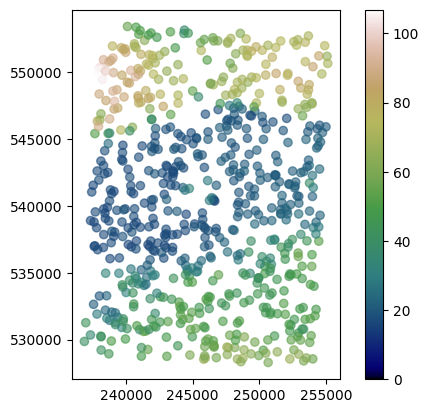

In [5]:
train.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True)
train.head()

We have removed a subset of points from a dataset to be sure that Kriging is working. In this scenario, 90% of available points are removed, but in real-world cases, you will probably have even fewer points to perform estimations, down to the ~1% of known values.

We have two variables right now:

- `train`: training set used for semivariogram model derivation,
- `test`: test set used for the model error calculation.

The worst idea is to take sample as `k first values` from the list. Let's imagine we have a sorted list of Digital Elevation Model points. The western part of our measurements covers a mountain, and the eastern part is plain. When we use the part of the west for modeling and the east part for tests, we are going directly into a catastrophe! **Points for each set are chosen randomly** to avoid bias related to the geographical location, but we cannot be sure that the sampled points are not from the neighborhood, thus in a fully controlled scenario we perform this experiment multiple times sampling dataset dozens or hundreds of times.

Having datasets, we can start modeling. Kriging requires fitted theoretical semivariogram.

In [6]:
step_size = 500  # meters
max_range = 10000  # meters

exp_var = build_experimental_variogram(
    ds=train[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

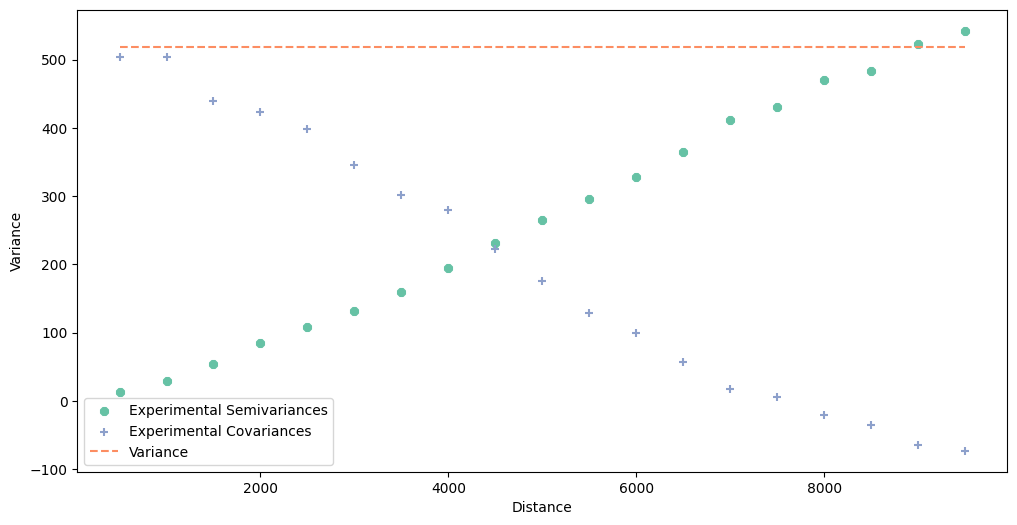

In [7]:
exp_var.plot();

In [8]:
theo_var = build_theoretical_variogram(
    experimental_variogram=exp_var,
    models_group='linear'
)

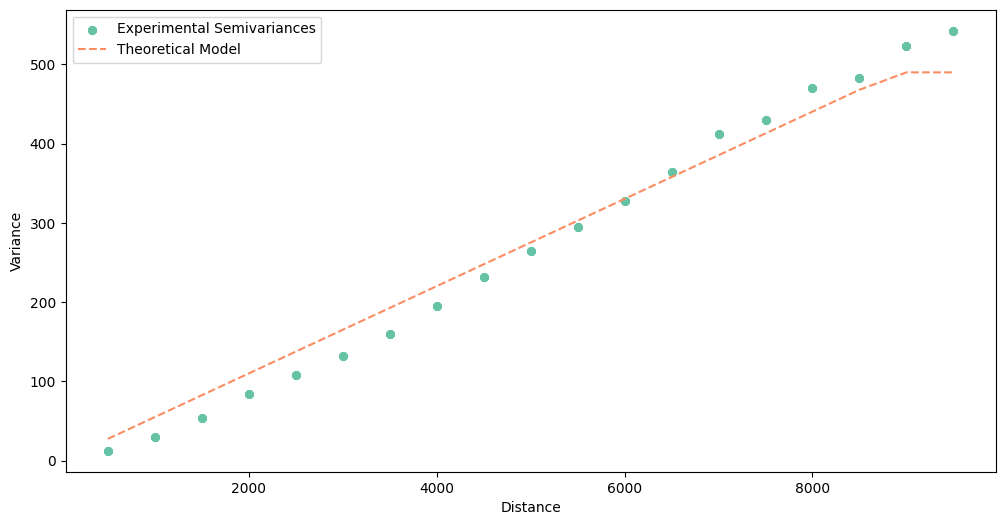

In [9]:
theo_var.plot()

In [10]:
print(theo_var)

* Selected model: Linear model
* Nugget: 0.0
* Sill: 489.7399812761576
* Range: 8898.981414538699
* Spatial Dependency Strength is Undefined: nugget equal to 0, cannot estimate
* Mean Bias: None
* Mean RMSE: 25.709962770143306
* Error-lag weighting method: equal


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 27.516631312210944 | 12.548872479116914 |  -14.96775883309403 |
| 1000.0 | 55.03326262442189  | 29.346216563217126 |  -25.68704606120476 |
| 1500.0 | 82.54989393663284  | 53.26039701343071  |  -29.28949692320213 |
| 2000.0 | 110.06652524884377 | 84.50844531675361  | -25.558079932090166 |
| 2500.0 | 137.5831565610547  | 108.53561182896007 |  -29.04754473209462 |
| 3000.0 | 165.09978787326568 | 131.69875148762813 |  -33.40103638563755 |
| 3500.0 | 192.61641918547662 | 159.39614083991057 | -33.220

## 2. Create Ordinary and Simple Kriging models

This is the essential step of our tutorial. We've fit semivariances to the model that is utilized by Kriging algorithm. Knowing this model, we can interpolate values in empty locations.

We will *predict* a known and arbitrary point in the first run. It is not a real prediction, but test of Kriging. When we perform Kriging, we should get the same exact values as in training data because Kriging is an unbiased linear estimator. Then, we will interpolate values at unknown locations given in the test set, and calculate the Root Mean Squared Error (RMSE) between those predicted and real values.

Functions `ordinary_kriging()` and `simple_kriging()` are similar, there is only one parameter that is different - `process_mean`, and it is passed only to the `simple_kriging()` function. Kriging parameters are:

- `theoretical_model`: fitted `TheoreticalVariogram` model
- `known_locations`: array with known points
- `unknown_locations`: locations where you want to interpolate a missing value (or a single location)
- `neighbors_range`: optional parameter, the maximum distance where we search for point neighbors. If you don't provide it then it is equal to the range of theoretical variogram model
- `no_neighbors`: number of the closest neighbors used for interpolation, by default it is set to 4, but for datasets with many point samples it is recommended to use more neighbors
- `max_tick`: If searching for neighbors in a specific direction how large should be tolerance for increasing the search angle (how many degrees more)
- `use_all_neighbors_in_range`: boolean parameter. `True`: if the number of neighbors within the `neighbors_range` is greater than the `no_neighbors`, then take all of them for modeling. Otherwise, take only n-closest neighbors
- `allow_approx_solutions`: Allows the approximation of kriging weights based on the OLS algorithm. This is by default set to `False`, and parameter is useful for debugging purposes. Do not ignore errors coming from the Kriging system because usually those errors inform you about data quality (duplicated coordinates, clusters, etc.)
- `process_mean`: The mean value of a process over a study area. Should be known before processing. That's why Simple Kriging has a limited number of applications. You must have multiple samples and well-known area to know this parameter.

We use only the first four parameters and `process_mean` when we run Simple Kriging. Let's start! The first step is an interpolation of the value known by our model.

In [11]:
# Select one known value

known_value = train.sample()
known_value

,longitude,latitude,dem,geometry
42,15.116427,52.675932,16.002563,POINT (237556.735 541547.696)


In [24]:
# Predict with Ordinary Kriging

unknown_location = known_value.geometry.iloc[0]
print(unknown_location)

POINT (237556.73506526498 541547.6959364694)


In [25]:
ok_interpolation = ordinary_kriging(
    theoretical_model=theo_var,
    known_locations=train[['geometry', 'dem']],
    unknown_locations=unknown_location,
    progress_bar=False
)
print(ok_interpolation)

[[1.60025635e+01            nan 2.37556735e+05 5.41547696e+05]]


In [26]:
print(known_value['dem'] - ok_interpolation[0][0])

42    0.0
Name: dem, dtype: float64


The first value is our prediction is precisely the same as the input in the training set! So far, the algorithm has worked well. The second value is prediction variance error, equal, or really close to zero - as it should be.

Simple Kriging differs from Ordinary Kriging, and we must set the process mean to retrieve valid results. It is rarely the case. That's why Ordinary Kriging is the first choice for many applications. We know the global mean because we have the whole dataset, but in the real-world scenario, we cannot divide the set into training and test sets and then get the mean from the entire dataset - it is an information leak from the test set into a model!

In [27]:
sk_interpolation = simple_kriging(
    theoretical_model=theo_var,
    known_locations=train[['geometry', 'dem']],
    unknown_locations=unknown_location,
    process_mean=np.mean(df['dem'])
)
print(sk_interpolation)

100%|██████████| 1/1 [00:00<00:00, 1117.29it/s]

[[1.60025635e+01            nan 2.37556735e+05 5.41547696e+05]]


The Simple Kriging algorithm returns the same output as the Ordinary Kriging: `[prediction, error variance, pt x, pt y]`. Simple Kriging has returned the same value as the actual value fed to the algorithm.

## 3. Predict values at unknown locations and evaluate output

In this part of the tutorial we interpolate values at missing locations. Kriging does it (usually) better than other simple techniques like filling missing data with the averages or inverse distance weighting. Interpolation quality is driven mostly by a good semivariogram model, but we can make better predictions when we scan more neighbors around the missing location. We will test this assumption in the next step, validating output with test dataset, and calculating the root mean squared error of prediction.

We will perform those tests only for ordinary kriging, dividing dataset multiple times to get distribution of errors for each number of neighbors.

In [35]:
from tqdm import tqdm


neighbors_number = [4, 8, 16, 32, 64, 128, 256, 512]
number_of_trials = 10

outputs = []

for _ in range(number_of_trials):
    for nn in tqdm(neighbors_number):
        # Divide dataset into train and test set
        train = dem.sample(n=int(0.1*len(dem)))
        test = dem.loc[~dem.index.isin(train.index)]

        # Take sample from test, we don't need a whole dataset
        test_sample = test.sample(n=100)

        # Fit semivariogram model
        exp_var = build_experimental_variogram(
            ds=train[['geometry', 'dem']],
            step_size=step_size,
            max_range=max_range
        )
        theo_var = build_theoretical_variogram(
            experimental_variogram=exp_var,
            models_group='linear'
        )

        # Predict new values
        yhats = ordinary_kriging(
            theoretical_model=theo_var,
            known_locations=train[['geometry', 'dem']],
            unknown_locations=test_sample['geometry'],
            no_neighbors=nn,
            use_all_neighbors_in_range=False,
            progress_bar=False
        )
        yhats = yhats[:, 0]
        avg_rmse = np.sqrt(np.mean((test_sample['dem'] - yhats)**2))
        outputs.append([avg_rmse, nn])

100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


In [36]:
# create dataframe from results

df = pd.DataFrame(outputs, columns=['rmse', 'nn'])
df.head()

,rmse,nn
0,5.101683,4
1,5.606411,8
2,4.393895,16
3,5.314496,32
4,3.708283,64


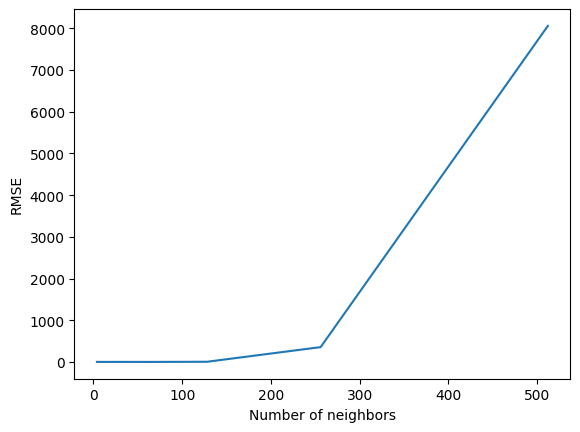

In [37]:
# First plot average rmse per number of neighbors

plt.figure()
plt.plot(df.groupby('nn')['rmse'].mean())
plt.xlabel('Number of neighbors')
plt.ylabel('RMSE')
plt.show()

As we see, there could be too many neighbors - interpolations become wildly inaccurate. We can check general statistics for each number of neighbors using `.describe()` method on transformed dataframe:

In [38]:
# First, set number of neighbors as a column

transformed = df.pivot(columns='nn', values='rmse')
transformed.head()

nn,4,8,16,32,64,128,256,512
0,5.101683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.606411,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.393895,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,5.314496,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,3.708283,NaN,NaN,NaN


In [39]:
transformed.describe()

nn,4,8,16,32,64,128,256,512
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.092391,4.359564,4.204688,4.736211,3.967083,7.702323,358.541137,8054.270265
std,0.772718,1.068681,0.571504,1.030644,0.352372,3.217012,310.411182,23070.277757
min,3.596085,3.521794,3.605129,3.563863,3.528472,3.848001,52.951256,207.031608
25%,5.033615,3.650415,3.839407,4.358459,3.716043,5.764558,176.471335,278.778854
50%,5.226161,4.037435,4.092138,4.510533,3.878133,6.801887,237.905790,471.083003
75%,5.616208,4.402573,4.363393,4.751882,4.205904,9.274566,465.388009,1486.446827
max,5.836839,6.842599,5.558488,7.348466,4.540467,15.034987,1021.542076,73672.777449


In general, too much neighbors might worsen the results; we are assuming, that the closest neighbors are the most important, and introducing more distant neighbors may amplify the noise in the model response.

The best idea is to look into semivariogram and limit range as much as you can. Then you will be sure, that only the closest neighbors are taken into account.

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-04-30 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |
| 2025-07-10 | Changed behavior of `ordinary_kriging` and simplified tutorial | @SimonMolinsky (Szymon Moliński) |